In [137]:
import pandas as pd

import string 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import demoji 
demoji.download_codes()

import imblearn

C:\Users\Loli\AppData\Local\Temp\ipykernel_5440\1706834518.py:10: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [138]:
posts_df = pd.read_csv('cleaned_posts.csv')
posts_df.head()

,postID,originalContent,date,link,sentiment,totalLikes,totalReplies,replyToPostID,taggedSymbols,username,userid,totalImages,totalSymbols
0,29104030,Vkl luôn,2024-11-06T21:39:23.267+07:00,NaN,0,1,0,NaN,"[{""symb"": ""^DJI"", ""price"": 43496.43}]",Hoàng,5ededf24-12f7-41d9-b390-08ff631fc275,0,1
1,29104026,Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...,2024-11-06T21:39:05.22+07:00,NaN,0,0,0,NaN,[],Datbg10,73778567-ec61-43eb-b3a0-b4a651b8bd3f,0,0
2,29104024,Tăng 1 phát bằng vn làm hai mấy năm :)),2024-11-06T21:39:04.077+07:00,NaN,0,12,2,NaN,"[{""symb"": ""^DJI"", ""price"": 43506.86}]",Trung Tuyến,5d597f38-3b24-4f40-952c-2b3f9be8e7d5,0,1
3,29104021,Má đáng full tiền...đau,2024-11-06T21:38:52.277+07:00,NaN,0,0,1,NaN,"[{""symb"": ""VNINDEX"", ""price"": 1261.28}]",Duc Nguyen,225659c6-cf18-4e93-aa39-a294bae5b784,1,1
4,29104019,Gap khủng long,2024-11-06T21:38:49.99+07:00,NaN,0,2,0,NaN,"[{""symb"": ""^DJI"", ""price"": 43499.54}]",BINH NHI,da8ebfa2-9cd5-4dbf-84cd-9567f694f681,0,1


In [139]:
stop_words = pd.read_csv('vietnamese-stopwords.csv')
stop_words = stop_words['word'].tolist()
stop_words = set(stop_words)

def preprocess_text_optimized(text):
    # Make all text lowercase
    text = text.lower()

    # Remove all symbols
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Replace all emojis with their descriptions
    text = demoji.replace_with_desc(text, sep = ' ')

    # Remove numbers and other special characters
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Remove stop words
    return ' '.join(word for word in text.split() if word not in stop_words)

In [140]:
# only keep the originalContent sentiment link columns
posts_after_cleaned = posts_df[['originalContent', 'sentiment', 'link']]

# not interested in neutral sentiment
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['sentiment'] != 0]

# not interested in posts with link
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['link'].isnull()]

# further remove contents contains link (http, https, www, .com)
posts_after_cleaned = posts_after_cleaned[~posts_after_cleaned['originalContent'].str.contains('http|https|www|.com')]

posts_after_cleaned.drop(columns=['link'], inplace=True)

# process the text
posts_after_cleaned['originalContent'] = posts_after_cleaned['originalContent'].apply(preprocess_text_optimized)

# remove rows with content length <= 5
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['originalContent'].apply(lambda x: len(x) > 5)]
posts_after_cleaned.dropna(inplace=True)

# reindex 
posts_after_cleaned.reset_index(drop=True, inplace=True)

In [141]:
cursed_words = pd.read_csv('Vietnamese_cursed_words.txt')
cursed_words = cursed_words['word'].tolist()
cursed_words = set(cursed_words)

def contains_cursed_words(text):
    words = text.lower().split()
    # return number of cursed words in the text
    number_of_cursed_words = sum(1 for word in words if word in cursed_words)
    if number_of_cursed_words > 0:
        return number_of_cursed_words
    return 0

posts_after_cleaned[['noCursedWord']] = posts_after_cleaned['originalContent'].apply(
    contains_cursed_words
).apply(pd.Series)

In [142]:
posts_after_cleaned[posts_after_cleaned['noCursedWord'] > 2].head(20)

,originalContent,sentiment,noCursedWord
31,đọc mãi báo đéo công văn quyết định thu hồi đé...,-1,4
56,láo vãi lồn đạp atc kéo địt liên,1,4
119,phục hồi tâm lý tích cực donald trump tái đắc ...,1,4
130,vib nim thu hẹp kéo lợi nhuận sụt check mark b...,1,3
626,thằng tuấn it đc đánh láo vãi lồn,-1,3
1252,giai đoạn cực kỳ nhầm lẫn test no supply no de...,-1,3
1458,hạ chó đi liếm lồn gái đồ sơnhải phòng emtao g...,-1,3
1526,cập nhật trạng thái nổi bật fire fire fire chứ...,1,6
1555,cập nhật trạng thái nổi bật fire fire fire chứ...,1,5
1597,xét yếu tố quan chủ quan động mục đích thằng x...,1,3


In [143]:
# count values
posts_after_cleaned['sentiment'].value_counts()

sentiment
 1    21159
-1    11771
Name: count, dtype: int64

Creating word clouds...


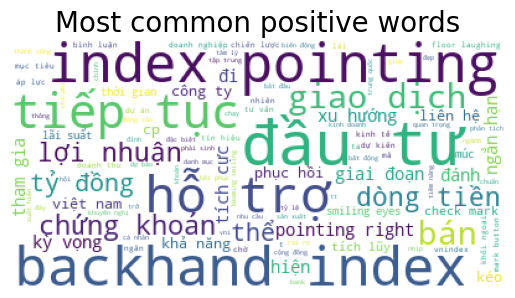

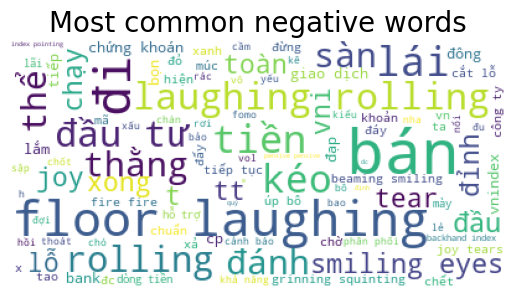

In [144]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def generate_wordcloud(words,sentiment):
    plt.figure()
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(random_state=42), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(posts_after_cleaned[posts_after_cleaned['sentiment'] == 1]['originalContent'].values)
negative_words=" ".join(posts_after_cleaned[posts_after_cleaned['sentiment'] == -1]['originalContent'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

In [152]:
from sklearn.model_selection import train_test_split

# Undersampling the majority class, then split the data
posts_after_cleaned_orig = posts_after_cleaned.copy()
positive_samples = posts_after_cleaned_orig[posts_after_cleaned_orig['sentiment'] == 1]
negative_samples = posts_after_cleaned_orig[posts_after_cleaned_orig['sentiment'] == -1]

# Undersample the positive class
positive_samples = positive_samples.sample(n=len(negative_samples), random_state=69)

# Concatenate the two classes
posts_after_cleaned_RandomUnderSampling = pd.concat([positive_samples,negative_samples])

X_train_pre = posts_after_cleaned_RandomUnderSampling.drop("sentiment",axis=1)
y_train_pre = posts_after_cleaned_RandomUnderSampling["sentiment"]

X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_train_pre,y_train_pre,test_size = 0.15, random_state=69, stratify=y_train_pre)  # 85% for training
X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_test_pre,y_test_pre,test_size = 0.5, random_state=69, stratify=y_test_pre)        # 7.5% for validation, 7.5% for testing

print(posts_after_cleaned_RandomUnderSampling['sentiment'].value_counts())

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train_pre),len(y_val_pre),len(y_test_pre)))
print("Training data distribution:\n",y_train_pre.value_counts())
print("Validation data distribution:\n",y_val_pre.value_counts())
print("Testing data distribution:\n",y_test_pre.value_counts())

sentiment
 1    11771
-1    11771
Name: count, dtype: int64
Data distribution:
- Train: 20010 
- Validation: 1766 
- Test: 1766
Training data distribution:
 sentiment
 1    10005
-1    10005
Name: count, dtype: int64
Validation data distribution:
 sentiment
 1    883
-1    883
Name: count, dtype: int64
Testing data distribution:
 sentiment
-1    883
 1    883
Name: count, dtype: int64


In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit: TfidfVectorizer):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

# Create tfidf base fit
tfidf = TfidfVectorizer(analyzer = 'word', min_df=40, max_df=0.2)
tfidf_vect_fitted=tfidf.fit(posts_after_cleaned_orig['originalContent'])

# Vectorize the training data
X_train=vectorize(X_train_pre['originalContent'],tfidf_vect_fitted)
X_train['noCursedWord'] = X_train_pre['noCursedWord']

y_train=y_train_pre.copy()

X_train.shape

(20010, 1626)

In [147]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [148]:
# RF without hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scoring = ["accuracy", "balanced_accuracy"]
rf = RandomForestClassifier(n_jobs=-1)
cv_res = cross_validate(rf, X_train, y_train, scoring=scoring)

print(f"General accuracy: {cv_res["test_accuracy"].mean()}")
print(f"Balanced accuracy: {cv_res["test_balanced_accuracy"].mean()}")

General accuracy: 0.7307346326836581
Balanced accuracy: 0.7307346326836581


In [13]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [50,100,200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [30,None]
}

cv = GridSearchCV(rf,parameters, n_jobs=-1)

cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

0.706 (+/-0.011) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 50}
0.703 (+/-0.015) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.702 (+/-0.017) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}
0.678 (+/-0.01) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 50}
0.684 (+/-0.01) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 100}
0.686 (+/-0.012) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 200}
0.732 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
0.732 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
0.736 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
0.736 (+/-0.01) for {'max_depth': None, 'max_features': 'log2', 'n_estimators': 50}
0.738 (+/-0.014) for {'max_depth': None, 'max_features': 'log2', 'n_estimators':

In [154]:
# Evaluate the model with optimal hyperparameters, using the validation set
import time

# Also calculate time (in ms) to evaluate the model

start = time.time()
rf1 = RandomForestClassifier(n_estimators=200, max_features = 'log2', max_depth=None, n_jobs=-1)
rf1.fit(X_train, y_train.values.ravel())
end = time.time()

print("Training time: ", end - start)

start = time.time()
rf2 = RandomForestClassifier(n_estimators=100, max_features = 'log2', max_depth=None, n_jobs=-1)
rf2.fit(X_train, y_train.values.ravel())    
end = time.time()

print("Training time: ", end - start)

start = time.time()
rf3 = RandomForestClassifier(n_estimators=200, max_features = 'sqrt', max_depth=None, n_jobs=-1)
rf3.fit(X_train, y_train.values.ravel())    
end = time.time()

print("Training time: ", end - start)

Training time:  6.301703691482544
Training time:  3.421842575073242
Training time:  15.338544130325317


In [158]:
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support

# Vectorize the validation data
X_val=vectorize(X_val_pre['originalContent'], tfidf_vect_fitted)
X_val['noCursedWord'] = X_val_pre['noCursedWord']
y_val=y_val_pre.copy()

# Evaluate the models
for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    bal_acc = balanced_accuracy_score(y_val,y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
    print('MAX FEATURES: {} / NUMBER OF EST: {} -- Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(mdl.max_features,
                                                                         mdl.n_estimators,
                                                                         round(bal_acc,3),
                                                                         round(precision,3),
                                                                         round(recall,3),
                                                                         round(f1,3)))

MAX FEATURES: log2 / NUMBER OF EST: 200 -- Acc: 0.746 / Precision: 0.746 / Recall: 0.746 / F1: 0.746
MAX FEATURES: log2 / NUMBER OF EST: 100 -- Acc: 0.743 / Precision: 0.744 / Recall: 0.743 / F1: 0.743
MAX FEATURES: sqrt / NUMBER OF EST: 200 -- Acc: 0.737 / Precision: 0.737 / Recall: 0.737 / F1: 0.737


In [156]:
X_test = vectorize(X_test_pre['originalContent'],tfidf_vect_fitted)
X_test['noCursedWord'] = X_test_pre['noCursedWord']
y_test = y_test_pre.copy()

# Choose the best model, based on the validation set
mdl = rf1
y_pred = mdl.predict(X_test)

bal_acc = balanced_accuracy_score(y_test,y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('MAX FEATURES: {} / NUMBER OF EST: {} -- Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(mdl.max_features,
                                                                        mdl.n_estimators,
                                                                        round(bal_acc,3),
                                                                        round(precision,3),
                                                                        round(recall,3),
                                                                        round(f1,3)))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

MAX FEATURES: log2 / NUMBER OF EST: 200 -- Acc: 0.754 / Precision: 0.753 / Recall: 0.75 / F1: 0.754
              precision    recall  f1-score   support

          -1       0.74      0.77      0.76       883
           1       0.76      0.73      0.75       883

    accuracy                           0.75      1766
   macro avg       0.75      0.75      0.75      1766
weighted avg       0.75      0.75      0.75      1766



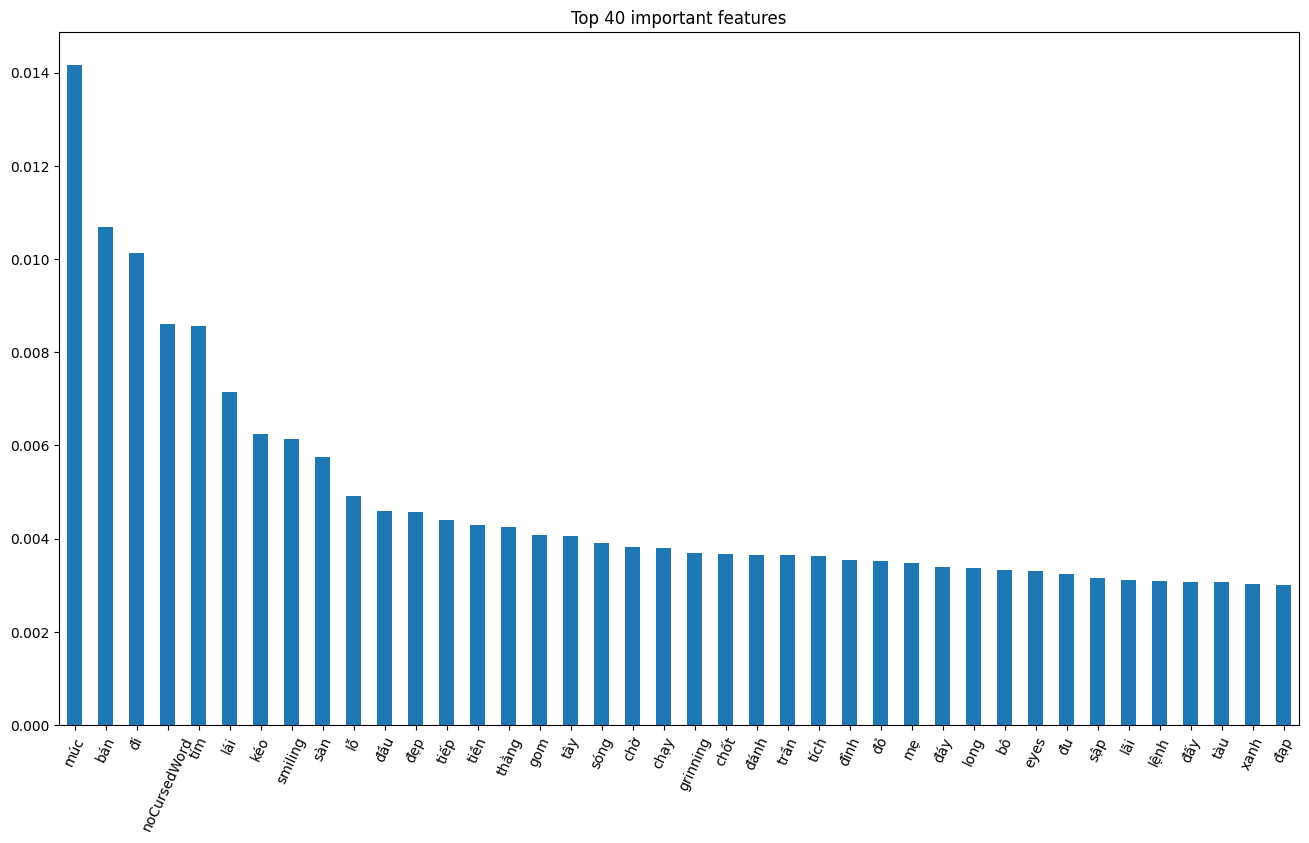

In [157]:
feat_importances = pd.Series(rf1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(40).plot(kind='bar',figsize=(16,9))
plt.xticks(rotation=65)
plt.title("Top 40 important features")
plt.show()

#### Thử thư viện `imbalanced-learn`

In [89]:
NUMBER_TEST_EACH = 900

posts_after_cleaned_imblearn = posts_after_cleaned.copy()

# Make sure the test set is balanced by manually undersampling the majority class
positive_samples = posts_after_cleaned_imblearn[posts_after_cleaned_imblearn["sentiment"] == 1]
negative_samples = posts_after_cleaned_imblearn[posts_after_cleaned_imblearn["sentiment"] == -1]

# Select the same number of positive samples as negative samples
posts_test_set_positive = positive_samples.sample(n=NUMBER_TEST_EACH, random_state=42)
posts_test_set_negative = negative_samples.sample(n=NUMBER_TEST_EACH, random_state=42)

# Concatenate the two classes
posts_test_set = pd.concat([posts_test_set_positive,posts_test_set_negative])
posts_train_set = posts_after_cleaned_imblearn.drop(posts_test_set.index)

X_train_imb = posts_train_set.drop("sentiment",axis=1)
y_train_imb = posts_train_set["sentiment"]

X_test_imb = posts_test_set.drop("sentiment",axis=1)
y_test_imb = posts_test_set["sentiment"]

# Vectorize the training data
X_train_imb = vectorize(X_train_imb['originalContent'],tfidf_vect_fitted)
X_train_imb['noCursedWord'] = posts_train_set['noCursedWord']

X_test_imb = vectorize(X_test_imb['originalContent'],tfidf_vect_fitted)
X_test_imb['noCursedWord'] = posts_test_set['noCursedWord']

# Fill nan with 0
X_train_imb.fillna(0,inplace=True)
X_test_imb.fillna(0,inplace=True)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(y_train_imb),len(y_test_imb)))
print("Training data distribution:\n",y_train_imb.value_counts())
print("Testing data distribution:\n",y_test_imb.value_counts())

Data distribution:
- Train: 31076 
- Test: 1800
Training data distribution:
 sentiment
 1    20264
-1    10812
Name: count, dtype: int64
Testing data distribution:
 sentiment
 1    900
-1    900
Name: count, dtype: int64


In [91]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

rf_clf = make_pipeline(
    BalancedRandomForestClassifier(
        sampling_strategy="all",
        n_estimators=200,
        max_features="log2",
        max_depth=None,
        replacement=True,
        bootstrap=False,
        random_state=42,
        n_jobs=-1,
    ),
)

scoring = ["accuracy", "balanced_accuracy"]
cv_res = cross_validate(rf_clf, X_train_imb, y_train_imb, scoring=scoring)

print(f"General accuracy: {cv_res["test_accuracy"].mean()}")
print(f"Balanced accuracy: {cv_res["test_balanced_accuracy"].mean()}")

# Fit the model
rf_clf.fit(X_train_imb, y_train_imb)

# Evaluate the model
y_pred = rf_clf.predict(X_test_imb)

bal_acc = balanced_accuracy_score(y_test_imb,y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_imb, y_pred, average='weighted')
print('Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(
                                                            round(bal_acc,3),
                                                            round(precision,3),
                                                            round(recall,3),
                                                            round(f1,3)))

print(classification_report(y_test_imb, y_pred))

General accuracy: 0.7303867403314918
Balanced accuracy: 0.7303867403314918
Acc: 0.737 / Precision: 0.738 / Recall: 0.737 / F1: 0.737
              precision    recall  f1-score   support

          -1       0.76      0.70      0.73       900
           1       0.72      0.77      0.75       900

    accuracy                           0.74      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.74      0.74      0.74      1800



In [92]:
from imblearn.under_sampling import (
    AllKNN,
    RepeatedEditedNearestNeighbours,
)

samplers = [
    AllKNN(allow_minority=True),
    RepeatedEditedNearestNeighbours(),
]

for sampler in samplers:
    print(f"Running {sampler}")
    X_train_imb_resampled, y_train_imb_resampled = sampler.fit_resample(X_train_imb, y_train_imb)
    print("Resampled data distribution:\n",y_train_imb_resampled.value_counts())

    cv_res = cross_validate(rf_clf, X_train_imb_resampled, y_train_imb_resampled, scoring=scoring)
    print(f"General accuracy: {cv_res["test_accuracy"].mean()}")
    print(f"Balanced accuracy: {cv_res["test_balanced_accuracy"].mean()}")
    print()

    # Fit the model
    rf_clf.fit(X_train_imb_resampled, y_train_imb_resampled)

    # Evaluate the model
    y_pred = rf_clf.predict(X_test_imb)
    bal_acc = balanced_accuracy_score(y_test_imb,y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_imb, y_pred, average='weighted')
    print('Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(
                                                            round(bal_acc,3),
                                                            round(precision,3),
                                                            round(recall,3),
                                                            round(f1,3)))
    print(classification_report(y_test_imb, y_pred))


Running AllKNN(allow_minority=True)
Resampled data distribution:
 sentiment
-1    8870
 1    7083
Name: count, dtype: int64
General accuracy: 0.8985142971661088
Balanced accuracy: 0.8965353386452714

Acc: 0.713 / Precision: 0.724 / Recall: 0.713 / F1: 0.71
              precision    recall  f1-score   support

          -1       0.67      0.82      0.74       900
           1       0.77      0.60      0.68       900

    accuracy                           0.71      1800
   macro avg       0.72      0.71      0.71      1800
weighted avg       0.72      0.71      0.71      1800

Running RepeatedEditedNearestNeighbours()
Resampled data distribution:
 sentiment
-1    10812
 1     7404
Name: count, dtype: int64
General accuracy: 0.8518335390820644
Balanced accuracy: 0.8515786780147991

Acc: 0.726 / Precision: 0.747 / Recall: 0.726 / F1: 0.72
              precision    recall  f1-score   support

          -1       0.67      0.87      0.76       900
           1       0.82      0.58      0.6